In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RB_Sentence1_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 5775
Neutral : 133685
Negative : 748


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1148


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Nature/Parks'][df1['TextBlob Polarity RBS1'] < 0]['RB_Sentence1'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['During Ethiopian rain season from June to August, trekking is not very '
 'popular due to the heavy and frequent rain showers.']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['during', 'ethiopian', 'rain', 'season', 'from', 'june', 'to', 'august', 'trekking', 'is', 'not', 'very', 'popular', 'due', 'to', 'the', 'heavy', 'and', 'frequent', 'rain', 'showers']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['during', 'ethiopian', 'rain', 'season', 'from', 'june', 'to', 'august', 'trekking', 'is', 'not', 'very', 'popular', 'due', 'to', 'the', 'heavy', 'and', 'frequent', 'rain', 'showers']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['rain', 'season', 'trek', 'due', 'heavy', 'frequent', 'rain', 'shower']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('due', 1),
  ('frequent', 1),
  ('heavy', 1),
  ('rain', 2),
  ('season', 1),
  ('shower', 1),
  ('trek', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.038*"local" + 0.036*"see" + 0.023*"also" + 0.023*"price" + '
  '0.023*"altitude" + 0.023*"walk" + 0.021*"short" + 0.017*"antelope" + '
  '0.017*"ostriche" + 0.017*"ranger"'),
 (1,
  '0.042*"decide" + 0.030*"lot" + 0.025*"cold" + 0.018*"review" + 0.018*"know" '
  '+ 0.018*"show" + 0.018*"area" + 0.018*"tripadvisor" + 0.018*"camping" + '
  '0.013*"venture"'),
 (2,
  '0.067*"week" + 0.057*"tour" + 0.034*"tribe" + 0.028*"spend" + 0.023*"make" '
  '+ 0.019*"village" + 0.018*"stay" + 0.016*"different" + 0.012*"ago" + '
  '0.012*"close"'),
 (3,
  '0.045*"guide" + 0.041*"travel" + 0.040*"little" + 0.031*"tour" + '
  '0.031*"tell" + 0.028*"day" + 0.026*"trek" + 0.021*"walk" + 0.021*"email" + '
  '0.018*"recommend"'),
 (4,
  '0.138*"day" + 0.126*"spend" + 0.056*"night" + 0.042*"visit" + 0.034*"trek" '
  '+ 0.024*"trip" + 0.022*"group" + 0.021*"child" + 0.019*"include" + '
  '0.018*"small"'),
 (5,
  '0.039*"begin" + 0.039*"experience" + 0.023*"close" + 0.023*"location" + '
  '0.023*"wee

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.580303573055965

Coherence Score:  0.446074394898312


In [17]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('time', 0.10810810810810811),
   ('drive', 0.08108108108108109),
   ('wife', 0.05405405405405406),
   ('long', 0.05405405405405406),
   ('couple', 0.04054054054054054),
   ('feel', 0.04054054054054054),
   ('country', 0.04054054054054054),
   ('individual', 0.02702702702702703),
   ('late', 0.02702702702702703),
   ('expensive', 0.02702702702702703)]),
 (1,
  [('night', 0.1797752808988764),
   ('include', 0.06741573033707865),
   ('due', 0.056179775280898875),
   ('family', 0.056179775280898875),
   ('make', 0.0449438202247191),
   ('find', 0.0449438202247191),
   ('south', 0.033707865168539325),
   ('experience', 0.033707865168539325),
   ('trekking', 0.02247191011235955),
   ('local', 0.02247191011235955)]),
 (2,
  [('spend', 0.46938775510204084),
   ('child', 0.05102040816326531),
   ('part', 0.04081632653061224),
   ('arrive', 0.04081632653061224),
   ('baboon', 0.02040816326530612),
   ('time', 0.02040816326530612),
   ('recently', 0.02040816326530612),
   ('vacation', 0.

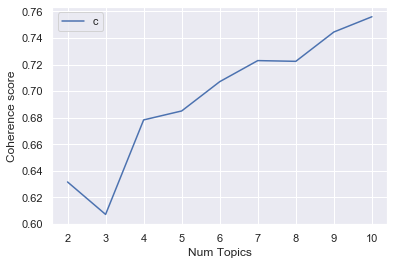

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6317
Num Topics = 3  has Coherence Value of 0.6072
Num Topics = 4  has Coherence Value of 0.6783
Num Topics = 5  has Coherence Value of 0.6851
Num Topics = 6  has Coherence Value of 0.7071
Num Topics = 7  has Coherence Value of 0.723
Num Topics = 8  has Coherence Value of 0.7224
Num Topics = 9  has Coherence Value of 0.7445
Num Topics = 10  has Coherence Value of 0.756


In [20]:
# optimal_model = model_list[8] # Number of Topics = 10

optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.323*"day" + 0.115*"long" + 0.062*"stay" + 0.042*"worth" + '
  '0.042*"experience" + 0.021*"absolutely" + 0.021*"recommend" + '
  '0.021*"camping" + 0.021*"nature" + 0.010*"itinerary"'),
 (1,
  '0.266*"day" + 0.160*"trek" + 0.053*"season" + 0.043*"part" + 0.043*"book" + '
  '0.032*"email" + 0.032*"minute" + 0.032*"cold" + 0.021*"include" + '
  '0.021*"endemic"'),
 (2,
  '0.281*"spend" + 0.135*"travel" + 0.045*"wife" + 0.022*"share" + '
  '0.011*"deer" + 0.011*"car" + 0.011*"bit" + 0.011*"afford" + 0.011*"plain" + '
  '0.011*"airport"'),
 (3,
  '0.170*"night" + 0.160*"spend" + 0.138*"tour" + 0.053*"due" + 0.032*"high" + '
  '0.021*"tribe" + 0.021*"difficult" + 0.021*"visit" + 0.011*"area" + '
  '0.011*"vacation"'),
 (4,
  '0.106*"visit" + 0.082*"small" + 0.071*"walk" + 0.071*"drive" + '
  '0.059*"child" + 0.047*"give" + 0.035*"local" + 0.035*"baboon" + '
  '0.024*"hour" + 0.024*"ago"'),
 (5,
  '0.102*"time" + 0.082*"tribe" + 0.071*"guide" + 0.051*"arrange" + '
  '0.031*"close" 

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1245,"day, trek, season, part, book, email, minute, ...",During Ethiopian rain season from June to Augu...
1,1,1.0,0.1259,"day, trek, season, part, book, email, minute, ...",DO NOT book your Simien mountain hike through ...
2,2,3.0,0.1152,"night, spend, tour, due, high, tribe, difficul...",I heard about the Simien mountains long before...
3,3,3.0,0.1189,"night, spend, tour, due, high, tribe, difficul...",I spent a week (Nov 2018) travelling around th...
4,4,6.0,0.1253,"short, spend, arrive, end, group, entrance, in...",We closed a deal for 3 days in the Simian Moun...
5,5,5.0,0.1131,"time, tribe, guide, arrange, close, animal, st...","Its a wonderous location, packed with the typi..."
6,6,3.0,0.1132,"night, spend, tour, due, high, tribe, difficul...","During the last Easter holiday, I spent the ti..."
7,7,2.0,0.1154,"spend, travel, wife, share, deer, car, bit, af...",I travelled to the Simiens with 8 other friends.
8,8,5.0,0.1513,"time, tribe, guide, arrange, close, animal, st...",On day one you trek along the road most of the...
9,9,6.0,0.1148,"short, spend, arrive, end, group, entrance, in...",If one wants to see the endemic mammal species...


In [22]:
df_dominant_topic['Dominant_Topic'].value_counts()

3.0    26
0.0    23
5.0    18
1.0    18
4.0    17
2.0    16
6.0    14
7.0    13
8.0     9
9.0     8
Name: Dominant_Topic, dtype: int64

In [36]:
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # General Criticism - 23
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Bad Weather - 18
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # General Criticism - 16
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # General Criticism - 26
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Discontent with Experience- 17
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Expensive Fees - 18
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Discontent with Experience- 14
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # General Criticism - 13
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # Discontent with Experience- 9
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 9]['Text'].values # General Criticism - 8

array(['I recently spent 2.5 weeks in Ethiopia, and my 3-day trek through the Ethiopian Highlands and up Abune Yosef was the highlight of my travels!',
       'We spent in Ethiopia almost 3 weeks between 3 and 21 of February 2015.',
       'We spent one week in Omo Valley in January.',
       'The guide books lead one to believe that one can still visit the Simiens in the rainy season, because the rain is limited to short downpours which only affect part of any given day.',
       'This time we did a short, half day hike only.',
       'I spent 2 days trekking the Simiens in December 2014 with a friend of mine.',
       'I just returned from a week long trip to Omo Valley.',
       'The Ezana Park in Axum is at the junction between the town center and the Stele Park.'],
      dtype=object)

In [37]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1548,"day, long, stay, worth, experience, absolutely...",The four day trip in the Simiens was absolutel...
1,1.0,0.1593,"day, trek, season, part, book, email, minute, ...",I went to Simien National Park for a day trip ...
2,2.0,0.1548,"spend, travel, wife, share, deer, car, bit, af...",a lot of fluffy reviews for run of the mill to...
3,3.0,0.1533,"night, spend, tour, due, high, tribe, difficul...",Utilizing the services of Imagine Ethiopia Tou...
4,4.0,0.1785,"visit, small, walk, drive, child, give, local,...",We drove with a jeep around the park for a cou...
5,5.0,0.1513,"time, tribe, guide, arrange, close, animal, st...",On day one you trek along the road most of the...
6,6.0,0.1495,"short, spend, arrive, end, group, entrance, in...","I was ""forced"" by my daughter to go on a short..."
7,7.0,0.1494,"trip, guide, decide, make, bale, altitude, cal...",It was cold and the altitude kicked our ...bot...
8,8.0,0.1648,"camp, review, week, south, feel, find, people,...",I’m sorry this review is going to be long but ...
9,9.0,0.1528,"week, simien, recently, rain, hike, expensive,...",The guide books lead one to believe that one c...


In [38]:
sent_topics_sorteddf_mallet['Text'].values

array(['The four day trip in the Simiens was absolutely an unbelievable experience.',
       'I went to Simien National Park for a day trip in May, the good part is that its virtually devoid of travellers in this season, the bad part is that its quite dusty and dry in May.',
       'a lot of fluffy reviews for run of the mill tourist outfits and individuals by inexperienced and not very demanding touritstas here.',
       'Utilizing the services of Imagine Ethiopia Tours, my wife & I made a ten day expedition from Addis Ababa down to the Omo Valley.',
       'We drove with a jeep around the park for a couple hours and had a short walk with the local ranger to see the ostriches, small antelopes and birds.',
       'On day one you trek along the road most of the time and its dusty and noisy so try and start on the usual second day of the trek if possible.',
       'I was "forced" by my daughter to go on a short vacation just before year-end, when Europe and Asia are cold and South Americ

In [39]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics